## Alex's goals for visualizations as of 10/15:
1) Switch from Census Tract to Census Block Group, and then to Census Block, as the relevant unit for plotting -- DONE

2) Find a way to plot individual points on the graph (i.e. public housing locations, or individual incidents themselves) -- DONE

3) Get population data for each block group and plot Field Incident Reports Per Capita -- DONE

4) Do some preliminary mapping of just those incidents involving youth -- IN PROGRESS

5) Get race/income data for the block groups and prepare it for future plotting

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

In [2]:
# Import the ShapeFile that mapping programs use to store polygons representing geographic locations
shapefile_ma_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'tl_2019_25_tract','tl_2019_25_tract.shp')
map_df_ma = gpd.read_file(shapefile_ma_path)

In [3]:
# Keep a list of all census tracts in New Bedford
census_tracts_nb = [6501.01, 6501.02, 6502.01, 6502.02, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510.01, 6510.02, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528]
census_tracts_nb = [str(elem) for elem in census_tracts_nb]

In [4]:
# Make a copy of map_df_ma which only contains New Bedford's census tracts
map_df_nb = map_df_ma[map_df_ma['NAME'].isin(census_tracts_nb)]

<AxesSubplot:>

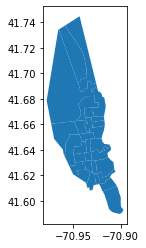

In [5]:
# Do a test plot of our map of New Bedford at the Census Tract level
map_df_nb.plot()

In [6]:
# Read in the Field Incident Reports dataset
fir_reports_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'field_incident_reports.csv')
fir_reports = pd.read_csv(fir_reports_path)

In [7]:
# For each incident report, create a special Point object that stores its latitude and longitude in an easy-to-read format
fir_reports['shapely.geometry.Point'] = fir_reports.apply(lambda x: Point(x['LONG'],x['LAT']), axis=1)

# Create a list of polygon objects corresponding to the census tracts
census_tract_polygons = map_df_nb['geometry'].to_list()

In [8]:
# Set up a dictionary mapping census tract numbers to the relevant Polygon as well as a count of the number of incidents recorded there
tract_number_to_polygon = dict.fromkeys(map_df_nb.index)
for key in tract_number_to_polygon.keys():
    tract_number_to_polygon[key] = (map_df_nb['geometry'].loc[key])

In [9]:
# Define a helper function to tell us in which census tract a particular incident occurred
def find_nb_census_tract(point):
    for i in range(len(map_df_nb.index)):
        if map_df_nb.iloc[i]['geometry'].contains(point):
            return map_df_nb.iloc[i]['NAME']

In [10]:
# For every incident report in the dataset, find its census tract
fir_reports['Census Tract'] = pd.DataFrame([find_nb_census_tract(fir_reports['shapely.geometry.Point'][i]) for i in range(len(fir_reports['shapely.geometry.Point']))])

In [11]:
# For every census tract, figure out how many field incident reports were recorded there
map_df_nb['Incident Count'] = map_df_nb.apply(lambda x: len(fir_reports[fir_reports['Census Tract']==x.NAME]),axis=1)

In [12]:
# Figure out how many incidents had issues with being matched up to a census tract: this turned out to be 40 of the 4997 reports filed
incidents_with_address_problems = len(fir_reports) - map_df_nb['Incident Count'].sum()
incidents_with_address_problems

40

<AxesSubplot:>

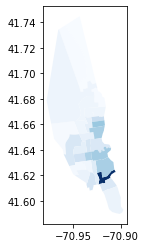

In [13]:
# Do a quick plot of incident counts per census tract: this is imperfect because one particularly problematic tract dominates the others
map_df_nb.plot(column='Incident Count',cmap='Blues')

In [18]:
# Take a look at the distribution of incident reports per tract, in order to determine how to break up the data into quantiles
incident_counts_sorted = map_df_nb['Incident Count'].to_list()
incident_counts_sorted.sort()

# Define a list of quintiles of the incident counts data; I might try doing some other interval length later on
quintile_boundaries = [['lower','upper'] for i in range(5)]
for i in range(5):
    if i == 0:
        quintile_boundaries[i][0] = 0
    else:
        quintile_boundaries[i][0] = incident_counts_sorted[i * len(incident_counts_sorted) // 5]
    if i == 4:
        quintile_boundaries[i][1] = incident_counts_sorted[-1] + 1
    else:
        quintile_boundaries[i][1] = incident_counts_sorted[(i+1) * len(incident_counts_sorted) // 5]

In [19]:
# Define a function to help us find where a point lies in a set of quintiles, which are expressed as lower (closed) and upper (open) bounds
def find_quantile(point, quantiles_list):
    for i in range(len(quantiles_list)):
        if point >= quantiles_list[i][0] and point < quantiles_list[i][1]:
            return i + 1

In [20]:
# Add a column to the census tract dataset which describes which quintile the incident count is in
map_df_nb['Incident Count Quintile'] = map_df_nb.apply(lambda x: find_quantile(x['Incident Count'], quintile_boundaries),axis=1)

Text(0.5, 1.0, 'Field Incident Reports in New Bedford\n(by Census Tract)')

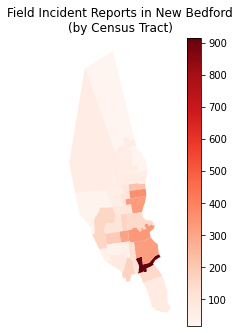

In [21]:
# Now, try plotting the same numbers as before, but based on percentiles of incident count numbers
incident_quintiles_plot = plt.figure()
iqp_axes = incident_quintiles_plot.add_axes([0,0,0.5,1])

iqp_plot = map_df_nb.plot(column='Incident Count',cmap='Reds',ax=iqp_axes,legend=True)#scheme='percentiles',legend=True)

# iqp_legend = iqp_plot.get_legend()
# iqp_legend.set_bbox_to_anchor([1.5,0.5,0.5,0.5])

iqp_axes.axis('off')
iqp_axes.set_title('Field Incident Reports in New Bedford\n(by Census Tract)')

## Switch from census tracts to block groups for plotting

In [22]:
# Import the ShapeFile that mapping programs use to store polygons representing geographic locations
shapefile_block_groups_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'tl_2019_25_bg','tl_2019_25_bg.shp')
block_groups_df_ma = gpd.read_file(shapefile_block_groups_path)

In [23]:
# Figure out which of Massachusetts's block groups are actually in New Bedford
census_tracts_nb_digits = census_tracts_nb.copy()
# Modify our list of New Bedford census tracts to have every one be exactly six digits long
for i in range(len(census_tracts_nb_digits)):
    if '.' in census_tracts_nb_digits[i]:
        census_tracts_nb_digits[i] = census_tracts_nb_digits[i].replace('.','')
    elif len(census_tracts_nb_digits[i]) == 4:
        census_tracts_nb_digits[i] = census_tracts_nb_digits[i] + "00"

bg_nb_boolean = block_groups_df_ma.apply(lambda x: x['TRACTCE'] in census_tracts_nb_digits,axis=1)
bg_nb = block_groups_df_ma[bg_nb_boolean]

In [24]:
# Define a helper function to tell us in which block group a particular incident occurred
def find_nb_block_group(point, block_groups):
    for i in range(len(block_groups.index)):
        if block_groups.iloc[i]['geometry'].contains(point):
            # We need a more detailed unique identifier for block groups: the GEOID, which combines state, county, census tract, and block number within that tract
            return block_groups.iloc[i]['GEOID']

In [25]:
# For each incident, find the block group where it occurred
fir_reports['Block Group'] = fir_reports.apply(lambda x: find_nb_block_group(x['shapely.geometry.Point'], bg_nb), axis=1)

# pd.DataFrame([find_nb_block_group(fir_reports['shapely.geometry.Point'][i], bg_nb) for i in range(len(fir_reports['shapely.geometry.Point']))])
# For each block group, sum up the number of incidents that occurred there
bg_nb['Incident Count'] = bg_nb.apply(lambda x: len(fir_reports[fir_reports['Block Group']==x.GEOID]),axis=1)

In [26]:
# Check on the number of incidents that had problems with being matched up to census tracts
incidents_address_problems_bg = len(fir_reports) - bg_nb['Incident Count'].sum()
incidents_address_problems_bg

52

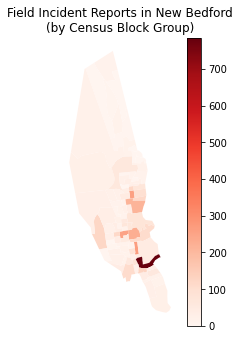

In [27]:
# Here, we'll plot incident percentiles at the Census Block Group level
incidents_by_bg = plt.figure()
ibbg_axes = incidents_by_bg.add_axes([0,0,0.5,1])

ibbg_plot = bg_nb.plot(column='Incident Count',cmap='Reds',ax=ibbg_axes,legend=True)#scheme='percentiles',legend=True)

# ibbg_legend = ibbg_plot.get_legend()
# ibbg_legend.set_bbox_to_anchor([1.5,0.5,0.5,0.5])

ibbg_axes.axis('off')
ibbg_axes.set_title('Field Incident Reports in New Bedford\n(by Census Block Group)')
incidents_by_bg.show()

## Look at incidents per capita to get another perspective on where the most Field Incident Reports are happening

In [28]:
# Import the Population By Block Group dataset
population_by_bg_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'NHGIS_pop_by_bg.csv')
pop_by_bg = pd.read_csv(population_by_bg_path)
pop_by_bg[pop_by_bg['GISJOIN']=='G25000506501013']

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,ZCTA5A,SUBMCDA,SDELMA,SDSECA,SDUNIA,PUMA5A,NAME,BTTRA,BTBGA,AJWME001
601,G25000506501013,2014-2018,NaN,NaN,Massachusetts,25,Bristol County,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 3, Census Tract 6501.01, Bristol C...",NaN,NaN,2015


In [29]:
# Add the population dataset's GISJOIN unique identifiers to the block groups & incident report numbers dataset, so we can match up block groups from both tables
bg_nb['GISJOIN'] = 'G' + bg_nb['STATEFP'] + '0' + bg_nb['COUNTYFP'] + '0' + bg_nb['TRACTCE'] + bg_nb['BLKGRPCE']

In [30]:
# Add a column to the main block groups dataset that contains the population of each block group
bg_nb['Population'] = bg_nb.apply(lambda x: pop_by_bg[pop_by_bg['GISJOIN']==x.GISJOIN]['AJWME001'].iloc[0], axis=1)

In [31]:
# Add an incidents per capita column to the block groups dataset
bg_nb['Incidents Per Capita'] = bg_nb['Incident Count'] / bg_nb['Population']

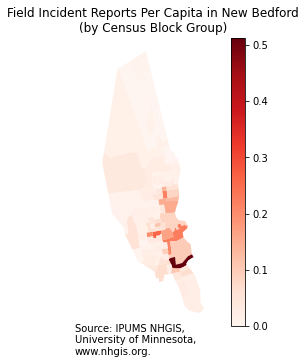

In [32]:
# Here, we'll plot incident percentiles at the Census Block Group level
incidents_by_pop = plt.figure()
ibp_axes = incidents_by_pop.add_axes([0,0,1,1])

ibp_plot = bg_nb.plot(column='Incidents Per Capita',cmap='Reds',ax=ibp_axes,legend=True)

# ibp_legend = ibp_plot.get_legend()
# ibp_legend.set_bbox_to_anchor([1.5,0.5,0.5,0.5])

ibp_axes.axis('off')
ibp_axes.set_title('Field Incident Reports Per Capita in New Bedford\n(by Census Block Group)')
ibp_plot.text(s='Source: IPUMS NHGIS,\nUniversity of Minnesota,\nwww.nhgis.org.',x=-0.2,y=-0.1,transform=ibp_axes.transAxes)
incidents_by_pop.show()

## Finally, plot individual report locations in addition to the general shapes of census block groups

In [39]:
# Grab the list of Point objects from the field incident reports table
incident_points = gpd.GeoSeries(fir_reports['shapely.geometry.Point'])

incident_lats_longs = fir_reports[['LAT','LONG']]

# Set up a GeoPandas Coordinate Reference System for the incident locations, in order to match it with the map of New Bedford
incident_points_crs = incident_points.set_crs(crs=blocks_nb.crs)

# Remove a couple of incidents that got mapped to locations OUTSIDE of New Bedford -- I don't yet know why this happened
incident_points_crs_cleaned = incident_points_crs[incident_lats_longs['LONG']>=-71]

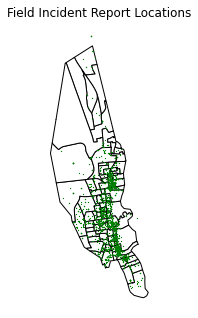

In [40]:
# On a single map, we'll plot both the Block Group boundaries and the locations of all field incident reports
bg_and_incidents_figure = plt.figure()
bgi_axes = bg_and_incidents_figure.add_axes([0,0,0.5,1])

bg_and_incidents_plot = bg_nb.plot(color='white',edgecolor='black',axes=bgi_axes)

incident_points_crs_cleaned.plot(ax=bgi_axes,marker="*",color='green',markersize=0.1)

bgi_axes.set_title('Field Incident Report Locations')
bgi_axes.axis('off')
bg_and_incidents_figure.show()

## One final idea: plot only those reports which involved stopping someone age 20 or younger

In [41]:
# Start by dropping one record with a missing value for age
fir_reports_youth = fir_reports[fir_reports['AGE']!='    ']
# Select only those reports where the person stopped was at most 20 years old
fir_reports_youth = fir_reports_youth[fir_reports_youth.apply(lambda x: int(x.AGE)<=20, axis=1)]

In [42]:
# Set up a series to hold just the points where incidents involving youths occurred
youth_incident_points = gpd.GeoSeries(fir_reports_youth['shapely.geometry.Point'])
youth_incident_points.set_crs(bg_nb.crs)

0       POINT (-70.92596 41.62694)
1       POINT (-70.92596 41.62694)
2       POINT (-70.92596 41.62694)
3       POINT (-70.92596 41.62694)
5       POINT (-70.94650 41.64428)
                   ...            
4975    POINT (-70.92888 41.62479)
4976    POINT (-70.92888 41.62479)
4977    POINT (-70.92888 41.62479)
4987    POINT (-70.92151 41.61912)
4993    POINT (-70.92092 41.61651)
Name: shapely.geometry.Point, Length: 1420, dtype: geometry

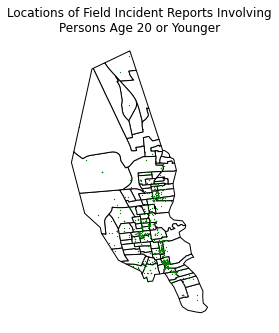

In [43]:
youth_incidents_figure = plt.figure()
yi_axes = youth_incidents_figure.add_axes([0,0,0.5,1])

youth_incidents_plot = bg_nb.plot(color='white',edgecolor='black',axes=yi_axes)

youth_incident_points.plot(ax=yi_axes,marker="*",color='green',markersize=0.1)

yi_axes.set_title('Locations of Field Incident Reports Involving\nPersons Age 20 or Younger')
yi_axes.axis('off')
youth_incidents_figure.show()

## Cleanup from current work: save all important datasets for future use
## This is from my very first analysis of the New Bedford data; not all the outputs below actually ended up getting used

In [244]:
# These are the two most important outputs that need to be saved in order to make my other New Bedford analysis notebooks work
bg_nb.to_file('block_groups_nb.json',driver='GeoJSON')
incident_points.to_file('incident_points_nb.json',driver='GeoJSON')

# Save as many of these datasets as possible so I won't have to run this notebook's time-consuming cells again in the future
map_df_nb.to_file('census_tracts_nb.json',driver='GeoJSON')
incident_points_crs.to_file('incident_points_crs.json',driver='GeoJSON')
incident_points_crs_cleaned.to_file('incident_points_crs_cleaned.json',driver='GeoJSON')
youth_incident_points.to_file('youth_incident_points.json',driver='GeoJSON')
fir_reports.to_hdf('field_incident_reports',key='fir')